In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

In [32]:
import seaborn as sns

In [33]:
from io import StringIO

In [11]:
from tqdm import tqdm_notebook as tqdmn

In [4]:
api_base = 'http://rating.chgk.info/api'

In [2]:
idteam = 38693

Get base town of the team

In [5]:
town = pd.read_json(requests.get(api_base + '/teams/{idteam}'.format(idteam=idteam)).text).town[0]
town

'Кемерово'

In [6]:
tournaments_response = requests.get(api_base + '/teams/{idteam}/tournaments'.format(idteam=idteam)).text

In [7]:
tournaments = pd.read_json(tournaments_response).transpose().reset_index(drop=True)
tournaments.head()

,idseason,idteam,tournaments
0,16,38693,"[1769, 1739]"
1,37,38693,"[2093, 2073, 2128, 1854, 1944, 1858, 1891]"
2,44,38693,"[2419, 2379, 2265, 2406, 2374, 2297, 2380, 251..."
3,45,38693,"[2856, 2873, 2776, 2791, 2790, 2889, 2909, 273..."
4,48,38693,"[3155, 3318, 3184, 3020, 3191, 3296, 2914, 289..."


In [8]:
tournaments_list = np.concatenate(tournaments.tournaments.tolist())

Receive tournaments results for this team

In [9]:
tournaments_list

array(['1769', '1739', '2093', '2073', '2128', '1854', '1944', '1858',
       '1891', '2419', '2379', '2265', '2406', '2374', '2297', '2380',
       '2512', '2314', '2225', '2181', '2166', '2248', '2232', '2246',
       '2147', '2077', '2155', '2165', '2164', '2185', '2180', '2856',
       '2873', '2776', '2791', '2790', '2889', '2909', '2732', '2834',
       '2857', '2709', '2833', '2749', '2824', '2817', '2787', '2782',
       '2807', '2578', '2694', '2789', '2786', '2689', '2708', '2745',
       '2696', '2727', '2585', '2707', '2662', '2660', '2659', '2632',
       '2506', '2472', '2479', '3155', '3318', '3184', '3020', '3191',
       '3296', '2914', '2899', '2961', '3217', '2994', '3116', '2913',
       '3007', '2993', '2975', '3006', '2797', '2912', '3081', '2992',
       '3032', '2911', '3004', '2904', '3003', '2881', '2942', '2896',
       '2997', '2884', '2859', '2843', '3862', '3736', '3828', '3833',
       '3329', '3689', '3494', '3599', '3493', '3328', '3656', '3492',
      

In [12]:
tournaments_results = [pd.read_json(requests.get(api_base + '/tournaments/{}/list'.format(t_id)).text) for t_id in tqdmn(tournaments_list)]

A Jupyter Widget

In [13]:
tournaments_results[46].head()

,base_name,bonus_a,bonus_b,current_name,d_bonus_a,d_bonus_b,d_diff_bonus,diff_bonus,idteam,included_in_rating,mask,position,predicted_position,questions_total,tech_rating
0,Афина,2280,1130,Афина,2280,1130,-128,-128,2,1,1.011110e+35,3.0,1.0,27,10330
1,Electronic wife,1655,243,Electronic wife,1655,243,-32,-32,172,1,1.110000e+33,145.0,102.0,13,1983
2,Гимназисты,0,727,Гимназисты,2224,727,5,5,185,1,1.011010e+35,25.0,27.0,22,3866
3,Десятый вал,2224,727,Десятый вал,2224,727,-40,-40,194,1,1.001001e+35,25.0,8.0,22,4871
4,БН,2290,1660,БН,2290,1660,435,435,205,1,1.111110e+35,1.0,11.0,29,4524


In [14]:
tournaments_results_merged = pd.concat([res.loc[res.idteam == idteam, :] for res in tqdmn(tournaments_results)]).reset_index(drop=True)

A Jupyter Widget

In [15]:
tournaments_results_merged['tournament_id'] = tournaments_list
tournaments_results_merged.head()

,base_name,bonus_a,bonus_b,current_name,d_bonus_a,d_bonus_b,d_diff_bonus,diff_bonus,idteam,included_in_rating,mask,position,predicted_position,questions_total,tech_rating,tournament_id
0,Аркашина каша,14,15,Аркашина каша,14,15,15,15,38693,1,1.011e+59,9.0,23,20,1,1769
1,Аркашина каша,0,1,Аркашина каша,0,1,1,1,38693,1,0,21.0,56.5,0,0,1739
2,Аркашина каша,405,111,Аркашина каша,405,111,86,86,38693,1,1.1111e+59,10.5,18,27,149,2093
3,Аркашина каша,195,63,Аркашина каша,195,63,34,34,38693,1,1.1011e+40,15.0,17,15,183,2073
4,Аркашина каша,387,103,Аркашина каша,387,103,46,46,38693,1,1.0001e+142,16.0,44,62,65,2128


Get info for places (no API for that, need to download temp)

In [17]:
representatives_request = 'http://rating.chgk.info/synch.php?download_data=requests_download&tournament_id={}'

In [22]:
%%time
representatives = pd.concat(
    tournaments_results_merged.tournament_id.apply(
        lambda x: pd.read_table(
            StringIO(
                requests.get(representatives_request.format(x)).text),
            sep=';').loc[lambda df: df['Город'] == town].assign(tournament_id=x)
    ).tolist()
).reset_index(drop=True)

representatives.columns = ['town', 'representative', 'narrator', 'status', 'n_teams', 'tournament_id']
representatives['actual_teams'] = representatives['n_teams'].apply(lambda x: int(x.split(' / ')[0]))

Wall time: 25.6 s


In [23]:
representatives.head()

,town,representative,narrator,status,n_teams,tournament_id,actual_teams
0,Кемерово,Кравцова Ирина Вячеславовна,Кравцова Ирина Вячеславовна,Принята,1 /,2419,1
1,Кемерово,Кравцова Ирина Вячеславовна,Кравцова Ирина Вячеславовна,Принята,1 /,2379,1
2,Кемерово,Юрлов Степан Сергеевич,Рыкова Юлия Владимировна,Принята,1 /,2265,1
3,Кемерово,Кравцова Ирина Вячеславовна,Драчёв Максим Вячеславович,Принята,0 /,2297,0
4,Кемерово,Кравцова Ирина Вячеславовна,Кравцова Ирина Вячеславовна,Принята,1 /,2314,1


We encount only in-town games here, thus inner join

In [24]:
tournaments_with_representatives = pd.merge(tournaments_results_merged, representatives, on='tournament_id', how='inner')

In [25]:
tournaments_with_representatives.head()

,base_name,bonus_a,bonus_b,current_name,d_bonus_a,d_bonus_b,d_diff_bonus,diff_bonus,idteam,included_in_rating,...,predicted_position,questions_total,tech_rating,tournament_id,town,representative,narrator,status,n_teams,actual_teams
0,Аркашина каша,1420,231,Аркашина каша,1420,231,11,11,38693,1,...,86,11,1088,2419,Кемерово,Кравцова Ирина Вячеславовна,Кравцова Ирина Вячеславовна,Принята,1 /,1
1,Аркашина каша,1977,510,Аркашина каша,1977,510,150,150,38693,1,...,124,19,1088,2379,Кемерово,Кравцова Ирина Вячеславовна,Кравцова Ирина Вячеславовна,Принята,1 /,1
2,Аркашина каша,1965,517,Аркашина каша,1965,517,162,162,38693,1,...,108.5,12,984,2265,Кемерово,Юрлов Степан Сергеевич,Рыкова Юлия Владимировна,Принята,1 /,1
3,Аркашина каша,837,177,Аркашина каша,837,177,16,16,38693,1,...,122,16,755,2297,Кемерово,Кравцова Ирина Вячеславовна,Драчёв Максим Вячеславович,Принята,0 /,0
4,Аркашина каша,953,165,Аркашина каша,953,165,27,27,38693,1,...,276,12,574,2314,Кемерово,Кравцова Ирина Вячеславовна,Кравцова Ирина Вячеславовна,Принята,1 /,1


In [26]:
tournaments_with_representatives.columns

Index(['base_name', 'bonus_a', 'bonus_b', 'current_name', 'd_bonus_a',
       'd_bonus_b', 'd_diff_bonus', 'diff_bonus', 'idteam',
       'included_in_rating', 'mask', 'position', 'predicted_position',
       'questions_total', 'tech_rating', 'tournament_id', 'town',
       'representative', 'narrator', 'status', 'n_teams', 'actual_teams'],
      dtype='object')

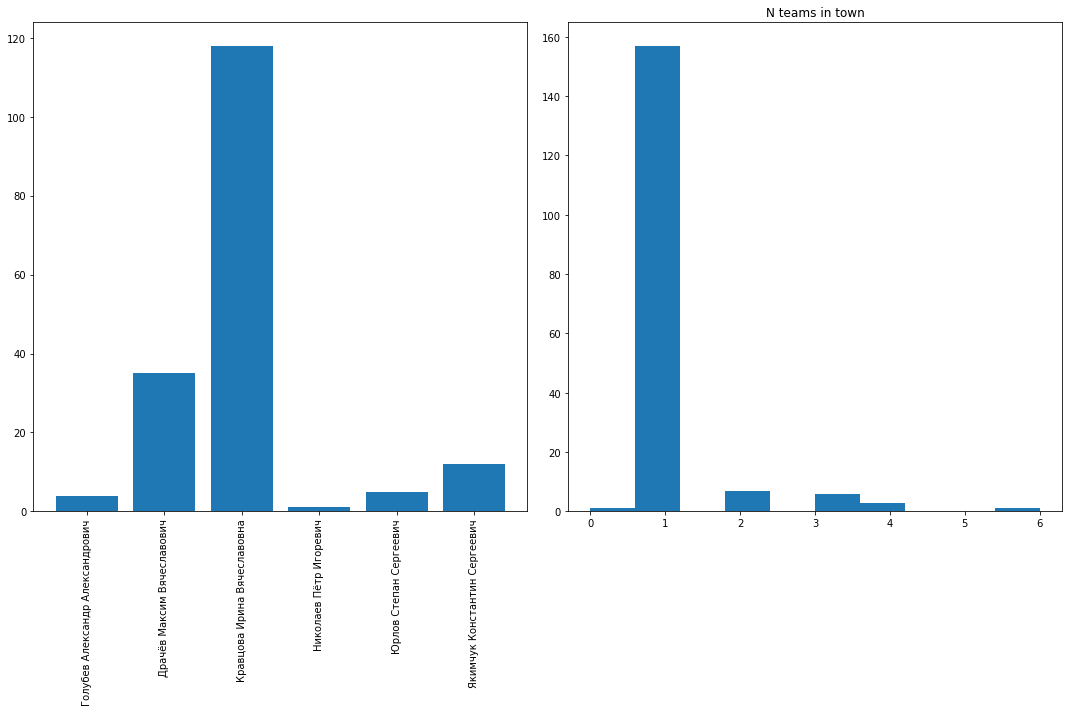

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
representatives_counts = np.unique(tournaments_with_representatives.representative, return_counts=True)
ax[0].bar(np.arange(len(representatives_counts[0])), representatives_counts[1])
ax[0].set_xticklabels(['']+list(representatives_counts[0]), rotation=90)

tournaments_with_representatives.actual_teams.hist(ax=ax[1], grid=False)
ax[1].set_title('N teams in town')

plt.tight_layout()
plt.show()

In [29]:
tournaments_with_representatives['mono'] = (tournaments_with_representatives.actual_teams == 1)

In [30]:
tournaments_with_representatives['diff_bonus'] = np.array(tournaments_with_representatives['diff_bonus'], dtype=np.int64)

In [35]:
labels = list(map(lambda x: x.get_text(), g.get_yticklabels()))

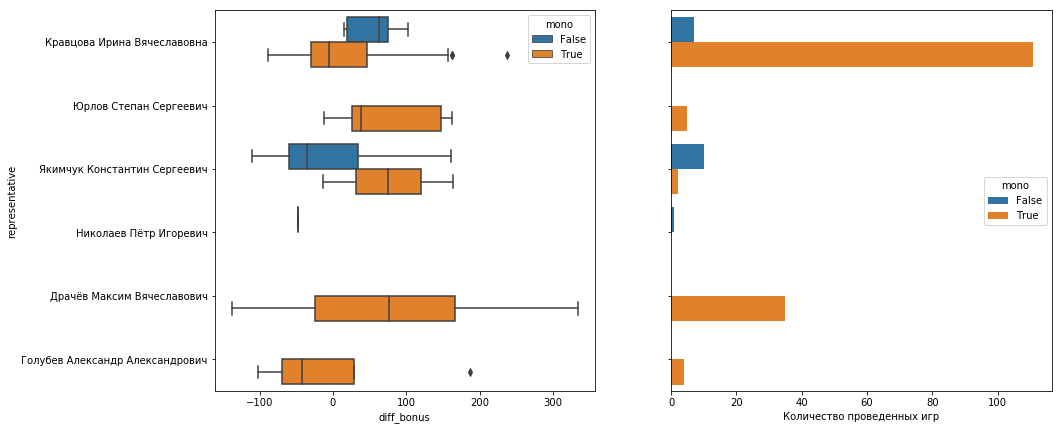

In [36]:
n_last_games = len(tournaments_with_representatives)
fig, ax = plt.subplots(ncols=2, figsize=(15, 7), sharey=True)
sns.boxplot(data=tournaments_with_representatives.tail(n_last_games), y='representative', x='diff_bonus', hue='mono', ax=ax[0])
sns.countplot(data=tournaments_with_representatives.tail(n_last_games), y='representative', hue='mono', ax=ax[1])

ax[1].set_xlabel('Количество проведенных игр')
ax[1].set_ylabel('')

# plt.suptitle('Бонус / представитель за все время')
plt.show()

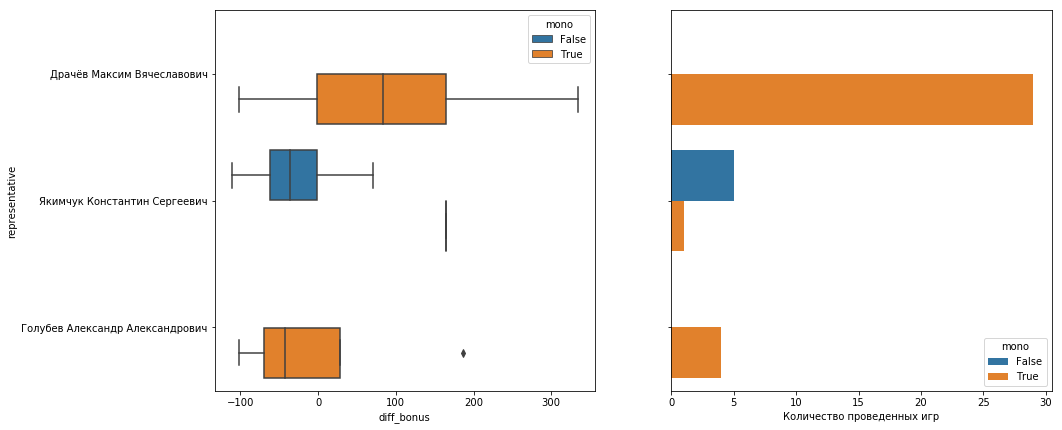

In [37]:
n_last_games = 39
fig, ax = plt.subplots(ncols=2, figsize=(15, 7), sharey=True)
sns.boxplot(data=tournaments_with_representatives.tail(n_last_games), y='representative', x='diff_bonus', hue='mono', ax=ax[0])
sns.countplot(data=tournaments_with_representatives.tail(n_last_games), y='representative', hue='mono', ax=ax[1])

ax[1].set_xlabel('Количество проведенных игр')
ax[1].set_ylabel('')

# plt.suptitle('Бонус / представитель за последние 2 сезона')
plt.show()

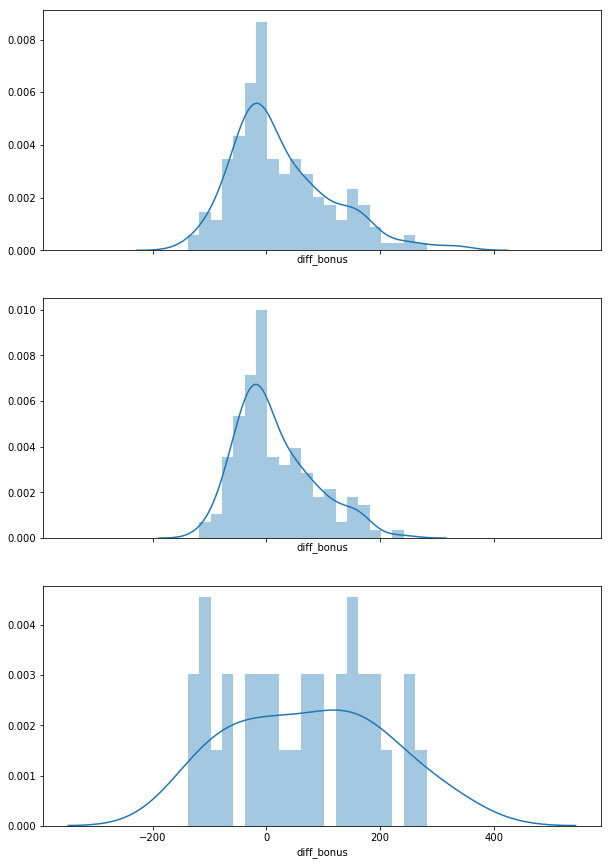

In [38]:
bins = np.arange(min(tournaments_with_representatives.diff_bonus), max(tournaments_with_representatives.diff_bonus), 20)
fig, ax = plt.subplots(nrows=3, figsize=(10, 15), sharex=True)
sns.distplot(tournaments_with_representatives.diff_bonus, bins=bins, ax=ax[0])
sns.distplot(tournaments_with_representatives.loc[tournaments_with_representatives.representative != 'Драчёв Максим Вячеславович',:].diff_bonus, bins=bins, ax=ax[1])
sns.distplot(tournaments_with_representatives.loc[tournaments_with_representatives.representative == 'Драчёв Максим Вячеславович',:].diff_bonus, bins=bins, ax=ax[2])
plt.show()

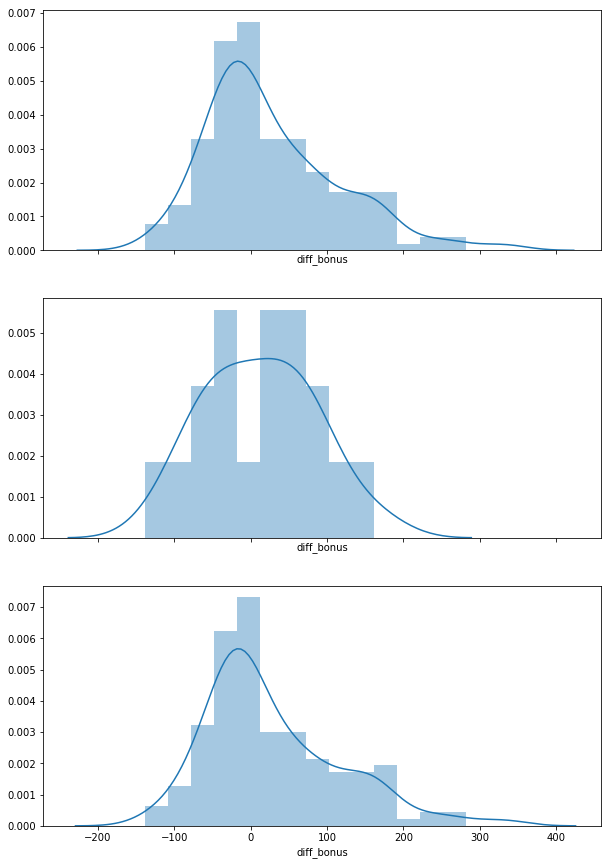

In [39]:
bins = np.arange(min(tournaments_with_representatives.diff_bonus), max(tournaments_with_representatives.diff_bonus), 30)
fig, ax = plt.subplots(nrows=3, figsize=(10, 15), sharex=True)

sns.distplot(tournaments_with_representatives.diff_bonus, bins=bins, ax=ax[0])
sns.distplot(tournaments_with_representatives.loc[tournaments_with_representatives.mono != True,:].diff_bonus, bins=bins, ax=ax[1])
sns.distplot(tournaments_with_representatives.loc[tournaments_with_representatives.mono == True,:].diff_bonus, bins=bins, ax=ax[2])
plt.show()